In [1]:
!git clone https://github.com/januar-png/earlystop.git

Cloning into 'earlystop'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 74 (delta 38), reused 17 (delta 7), pack-reused 0
Unpacking objects: 100% (74/74), 8.64 MiB | 6.85 MiB/s, done.


In [2]:
pip install jcopdl==1.1.1

  Preparing metadata (setup.py) ... - done
  Created wheel for jcopdl: filename=jcopdl-1.1.1-py2.py3-none-any.whl size=12589 sha256=d5390cea5db8916fcb7f4eb32c0103853afc88cb034131a49e7f800f5b3733fd
  Stored in directory: /root/.cache/pip/wheels/6d/46/c4/fbd4a6c344375a840af6eb98af862a0b12da406d4fbc2aa882
Successfully built jcopdl
Note: you may need to restart the kernel to use updated packages.


In [3]:
from jcopdl.layers import linear_block 
from jcopdl.callback import Callback

In [4]:
from earlystop import Earlystop

In [5]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
batch_size = 32
img_size = 224, 224

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('/kaggle/input/data-padi/train', transform = train_transform)
trainloader = DataLoader(train_set, batch_size, shuffle = True)

val_set = datasets.ImageFolder('/kaggle/input/data-padi/val', transform = val_transform)
valloader = DataLoader(val_set, batch_size, shuffle = False)

In [8]:
feature, label = next(iter(valloader))
print(feature.shape)

torch.Size([32, 3, 224, 224])


In [9]:
def ConvBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [10]:
class CNNpenyakitPadi(nn.Module):
    def __init__(self, output_size):
        super(CNNpenyakitPadi, self).__init__()
        self.feature = nn.Sequential(
            
            ConvBlock(3, 16),
            nn.MaxPool2d(2,2),
            
            ConvBlock(16, 32),
            nn.MaxPool2d(2,2),
            
            ConvBlock(32, 64),
            nn.MaxPool2d(2,2),
                         
            ConvBlock(64, 256),
            nn.MaxPool2d(2,2),
            
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            linear_block(256*14*14, 64, activation='relu', dropout=0.5),
            linear_block(64, output_size, activation='softmax')
        )
    def forward(self, x):
        x = self.feature(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [11]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [12]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

In [13]:
def fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device, scheduler, early_stop, epochs):
    for epoch in range(epochs):
        train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", val_set, valloader, model, criterion, optimizer, device)
        
        scheduler.step(test_cost)
        early_stop.log(train_cost, test_cost, train_score, test_score)

        if early_stop.early_stopping(model, monitor="test_cost") or epoch >= epochs - 1:
            early_stop.plot_cost()
            early_stop.plot_score()
            break

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNpenyakitPadi(output_size = len(train_set.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-6)
scheduler = ReduceLROnPlateau(optimizer, 'min',patience=1)
callback = Earlystop(model, outdir="model", early_stop_patience=2)
epoch = 50

In [15]:
1.0016-0.9945

0.007099999999999995

Test: 100%|██████████| 12/12 [00:28<00:00,  2.41s/it]


Epoch 1: train_loss=1.3815, val_loss=1.3825, train_score=0.2881, val_score=0.3056


Test: 100%|██████████| 12/12 [00:26<00:00,  2.22s/it]


Epoch 2: train_loss=1.3561, val_loss=1.3686, train_score=0.3667, val_score=0.3139


Test: 100%|██████████| 12/12 [00:26<00:00,  2.20s/it]


Epoch 3: train_loss=1.3304, val_loss=1.3548, train_score=0.4198, val_score=0.3333


Test: 100%|██████████| 12/12 [00:26<00:00,  2.20s/it]


Epoch 4: train_loss=1.3106, val_loss=1.3442, train_score=0.4532, val_score=0.3722


Test: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


Epoch 5: train_loss=1.2994, val_loss=1.3384, train_score=0.4571, val_score=0.3417


Test: 100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


Epoch 6: train_loss=1.2849, val_loss=1.3298, train_score=0.4786, val_score=0.3722


Test: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch 7: train_loss=1.2660, val_loss=1.3101, train_score=0.4881, val_score=0.4167


Test: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch 8: train_loss=1.2613, val_loss=1.3034, train_score=0.4984, val_score=0.4278


Test: 100%|██████████| 12/12 [00:26<00:00,  2.21s/it]


Epoch 9: train_loss=1.2436, val_loss=1.2916, train_score=0.5317, val_score=0.4333


Test: 100%|██████████| 12/12 [00:26<00:00,  2.20s/it]


Epoch 10: train_loss=1.2362, val_loss=1.2844, train_score=0.5119, val_score=0.4333


Test: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


Epoch 11: train_loss=1.2321, val_loss=1.2762, train_score=0.5325, val_score=0.4556


Test: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


Epoch 12: train_loss=1.2191, val_loss=1.2640, train_score=0.5389, val_score=0.4861


Test: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch 13: train_loss=1.2173, val_loss=1.2524, train_score=0.5437, val_score=0.5083


Test: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch 14: train_loss=1.2015, val_loss=1.2454, train_score=0.5746, val_score=0.5139


Test: 100%|██████████| 12/12 [00:26<00:00,  2.21s/it]


Epoch 15: train_loss=1.1920, val_loss=1.2345, train_score=0.5865, val_score=0.5222


Test: 100%|██████████| 12/12 [00:26<00:00,  2.20s/it]


Epoch 16: train_loss=1.1811, val_loss=1.2230, train_score=0.5984, val_score=0.5361


Test: 100%|██████████| 12/12 [00:26<00:00,  2.19s/it]


Epoch 17: train_loss=1.1780, val_loss=1.2161, train_score=0.5849, val_score=0.5583


Test: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


Epoch 18: train_loss=1.1703, val_loss=1.2131, train_score=0.6087, val_score=0.5444


Test: 100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


Epoch 19: train_loss=1.1685, val_loss=1.1941, train_score=0.6079, val_score=0.5833


Test: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch 20: train_loss=1.1569, val_loss=1.1862, train_score=0.6278, val_score=0.6000


Test: 100%|██████████| 12/12 [00:26<00:00,  2.21s/it]


Epoch 21: train_loss=1.1451, val_loss=1.1733, train_score=0.6325, val_score=0.6472


Test: 100%|██████████| 12/12 [00:26<00:00,  2.20s/it]


Epoch 22: train_loss=1.1438, val_loss=1.1657, train_score=0.6341, val_score=0.6528


Test: 100%|██████████| 12/12 [00:26<00:00,  2.20s/it]


Epoch 23: train_loss=1.1295, val_loss=1.1588, train_score=0.6508, val_score=0.6389


Test: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


Epoch 24: train_loss=1.1308, val_loss=1.1448, train_score=0.6437, val_score=0.6556


Test: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


Epoch 25: train_loss=1.1116, val_loss=1.1472, train_score=0.6698, val_score=0.6667
EarlyStop patience =  1. Best test_cost: 1.1448


Test: 100%|██████████| 12/12 [00:26<00:00,  2.22s/it]


Epoch 26: train_loss=1.1045, val_loss=1.1303, train_score=0.6905, val_score=0.6750


Test: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]


Epoch 27: train_loss=1.1053, val_loss=1.1259, train_score=0.6794, val_score=0.6889


Test: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


Epoch 28: train_loss=1.1060, val_loss=1.1269, train_score=0.6897, val_score=0.6944
EarlyStop patience =  1. Best test_cost: 1.1259


Test: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]


Epoch 29: train_loss=1.0860, val_loss=1.1209, train_score=0.7008, val_score=0.6944


Test: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


Epoch 30: train_loss=1.0917, val_loss=1.1150, train_score=0.6968, val_score=0.6972


Test: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch 31: train_loss=1.0761, val_loss=1.1109, train_score=0.7119, val_score=0.6917


Test: 100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


Epoch 32: train_loss=1.0705, val_loss=1.1001, train_score=0.7206, val_score=0.7167


Test: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


Epoch 33: train_loss=1.0778, val_loss=1.0970, train_score=0.7087, val_score=0.7167


Test: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


Epoch 34: train_loss=1.0636, val_loss=1.0835, train_score=0.7365, val_score=0.7389


Test: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


Epoch 35: train_loss=1.0570, val_loss=1.0838, train_score=0.7238, val_score=0.7306
EarlyStop patience =  1. Best test_cost: 1.0835


Test: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]


Epoch 36: train_loss=1.0509, val_loss=1.0803, train_score=0.7397, val_score=0.7250


Test: 100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


Epoch 37: train_loss=1.0557, val_loss=1.0775, train_score=0.7373, val_score=0.7278


Test: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]


Epoch 38: train_loss=1.0467, val_loss=1.0777, train_score=0.7437, val_score=0.7250
EarlyStop patience =  1. Best test_cost: 1.0775


Test: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


Epoch 39: train_loss=1.0472, val_loss=1.0640, train_score=0.7381, val_score=0.7417


Test: 100%|██████████| 12/12 [00:27<00:00,  2.25s/it]


Epoch 40: train_loss=1.0295, val_loss=1.0618, train_score=0.7548, val_score=0.7417


Test: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch 41: train_loss=1.0427, val_loss=1.0603, train_score=0.7444, val_score=0.7278


Test: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


Epoch 42: train_loss=1.0355, val_loss=1.0576, train_score=0.7595, val_score=0.7389


Test: 100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


Epoch 43: train_loss=1.0122, val_loss=1.0515, train_score=0.7889, val_score=0.7389


Test: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch 44: train_loss=1.0271, val_loss=1.0490, train_score=0.7595, val_score=0.7389


Test: 100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


Epoch 45: train_loss=1.0208, val_loss=1.0459, train_score=0.7643, val_score=0.7361


Test: 100%|██████████| 12/12 [00:26<00:00,  2.24s/it]


Epoch 46: train_loss=1.0215, val_loss=1.0443, train_score=0.7667, val_score=0.7472


Test: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]


Epoch 47: train_loss=1.0147, val_loss=1.0402, train_score=0.7659, val_score=0.7472


Test: 100%|██████████| 12/12 [00:26<00:00,  2.25s/it]


Epoch 48: train_loss=1.0167, val_loss=1.0364, train_score=0.7627, val_score=0.7500


Test: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]


Epoch 49: train_loss=1.0038, val_loss=1.0361, train_score=0.7778, val_score=0.7528


Test: 100%|██████████| 12/12 [00:26<00:00,  2.19s/it]


Epoch 50: train_loss=1.0025, val_loss=1.0339, train_score=0.7794, val_score=0.7500


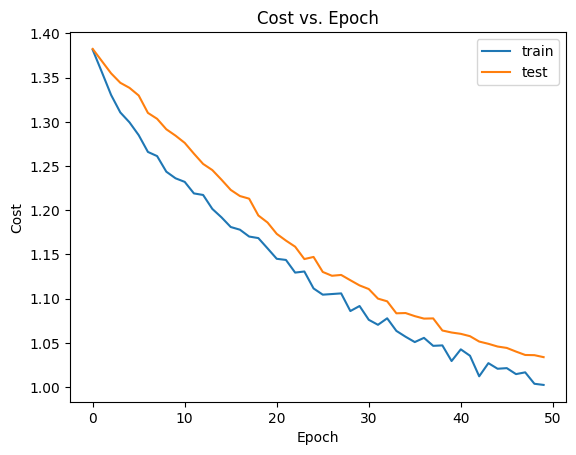

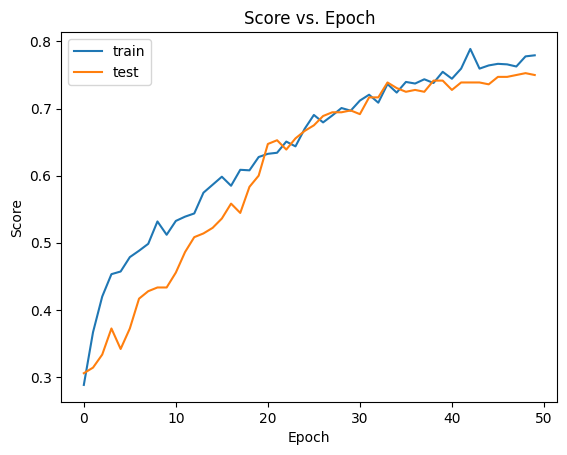

In [16]:
fit(train_set, trainloader, val_set, valloader, model, criterion, optimizer, device,scheduler, callback, epoch)

In [17]:
!pip install torchsummary

In [18]:
test_transform = transforms.Compose([
    transforms.Resize(size=(img_size)),
    transforms.ToTensor()
])
test_set = datasets.ImageFolder('/kaggle/input/data-padi/test', transform=test_transform)
testloader = DataLoader(test_set, shuffle=False)

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
def evaluate_model(model, testloader, criterion, device):
    model.load_state_dict(torch.load('/kaggle/working/model/best_model.pth'))
    model.eval()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    average_loss = total_loss / len(testloader)
    accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
    
    class_counts_labels = np.bincount(all_labels)
    class_counts_predictions = np.bincount(all_predictions)

    print(f'Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    print("Classification Report:")
    print(classification_report(all_labels, all_predictions))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_set.classes, yticklabels=test_set.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Test Loss: 1.0647, Test Accuracy: 0.6889
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60        45
           1       0.50      0.20      0.29        45
           2       0.79      0.91      0.85        45
           3       0.80      0.98      0.88        45

    accuracy                           0.69       180
   macro avg       0.66      0.69      0.65       180
weighted avg       0.66      0.69      0.65       180

Confusion Matrix:


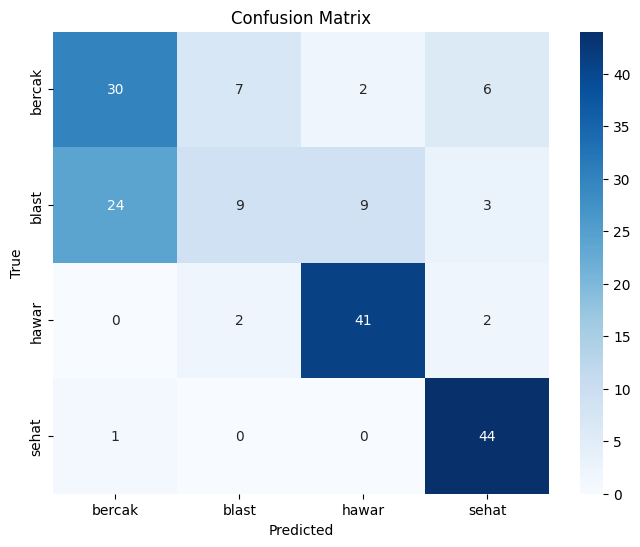

In [21]:
evaluate_model(model, testloader, criterion, device)

In [22]:
from torchsummary import summary

model = CNNpenyakitPadi(output_size = 6).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         MaxPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
         MaxPool2d-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         147,712
      BatchNorm2d-14          [-1, 256,

In [23]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


activation1 = {}
jumlah = 100

def get_activation(name):
    def hook(module, input, output):
        activation1[name] = output.detach()
    return hook

model.feature[0][0].register_forward_hook(get_activation('conv'))
model.feature[2][0].register_forward_hook(get_activation('conv2'))
model.feature[4][0].register_forward_hook(get_activation('conv4'))

model.feature[0][2].register_forward_hook(get_activation('relu'))
model.feature[2][2].register_forward_hook(get_activation('relu3'))
model.feature[4][2].register_forward_hook(get_activation('relu5'))


img = Image.open('/kaggle/input/data-padi/test/bercak/IMG000000000013.jpg')
rgb_image = img.convert('RGB')

transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])
img_tensor = transform(rgb_image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor

output = model(img_tensor)

/tmp/ipykernel_19/2727268787.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1)


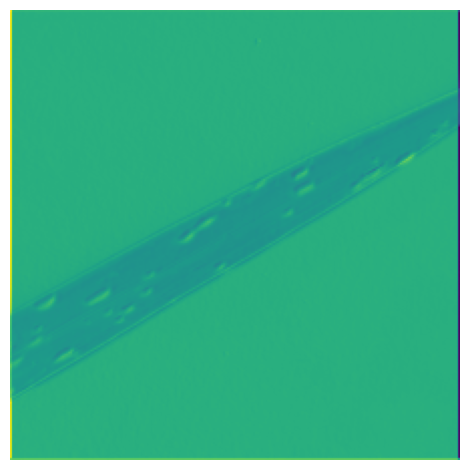

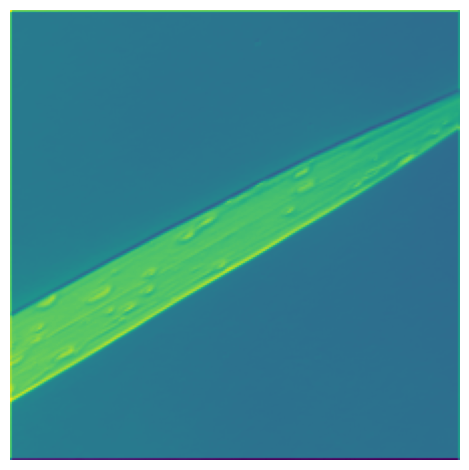

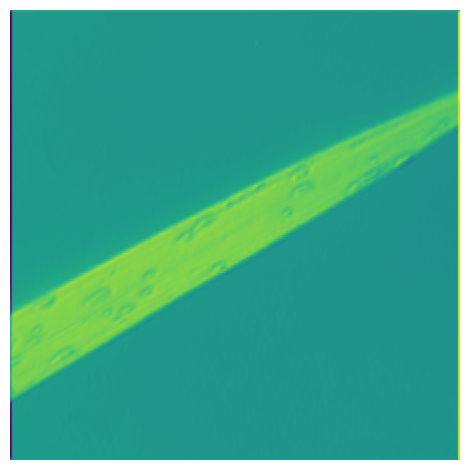

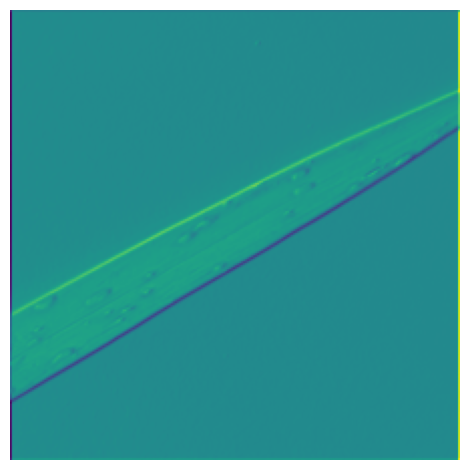

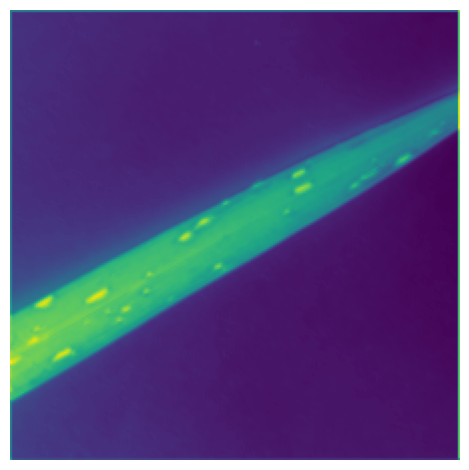

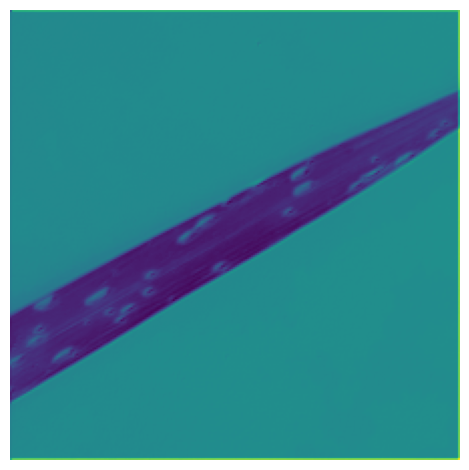

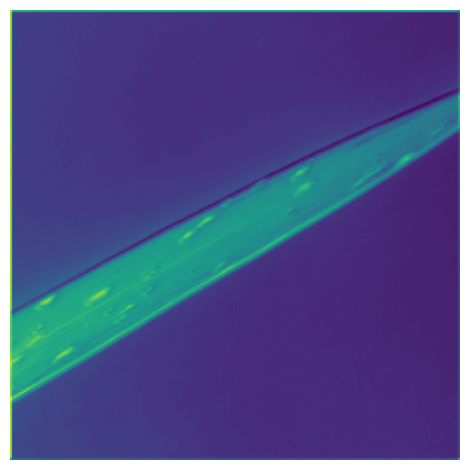

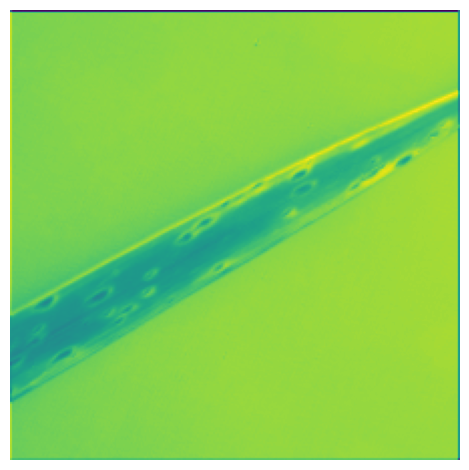

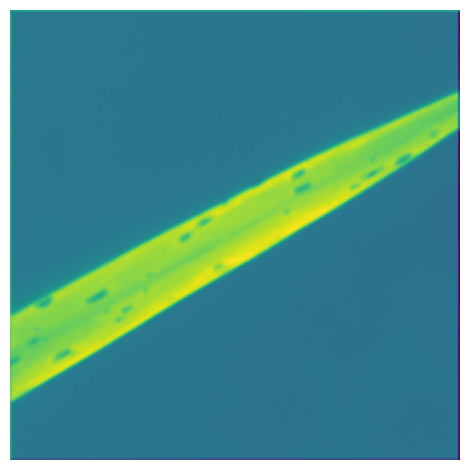

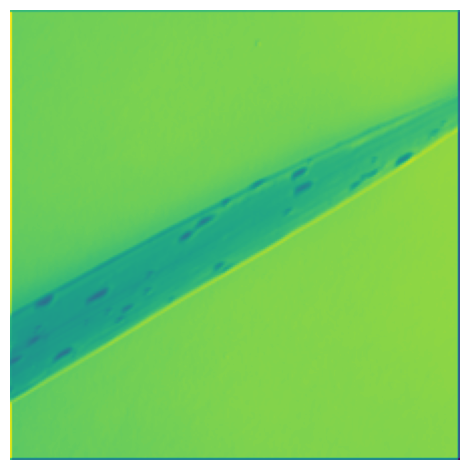

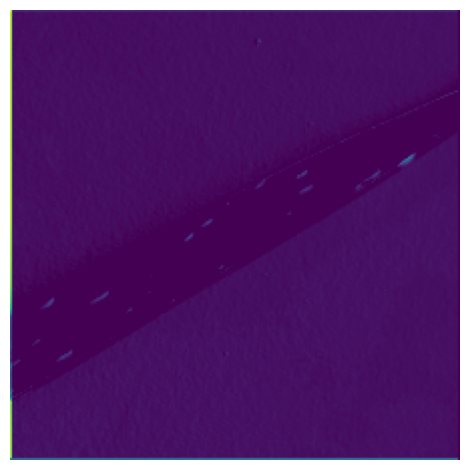

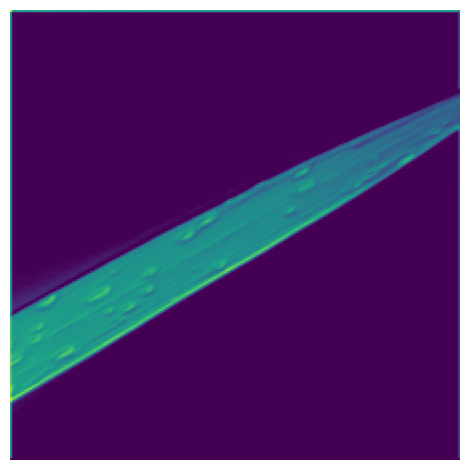

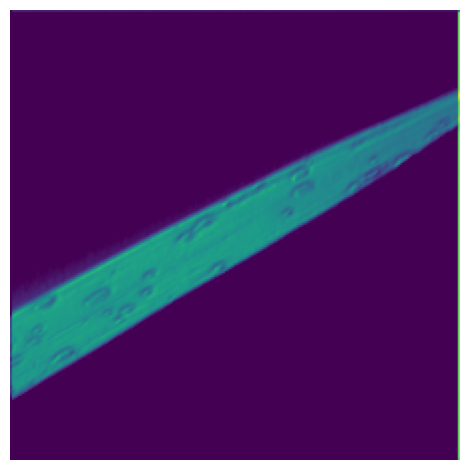

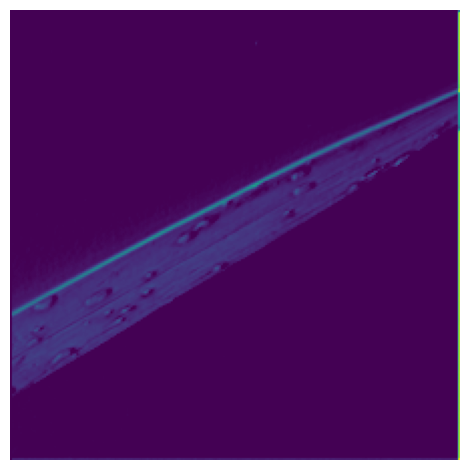

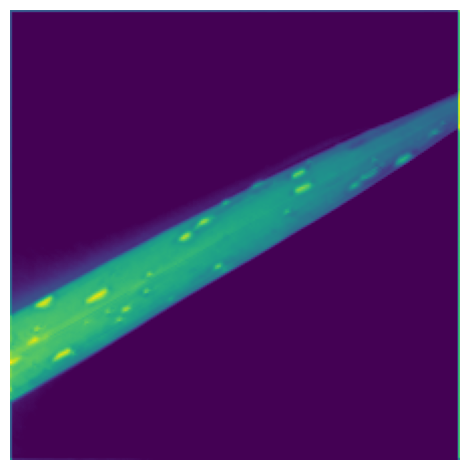

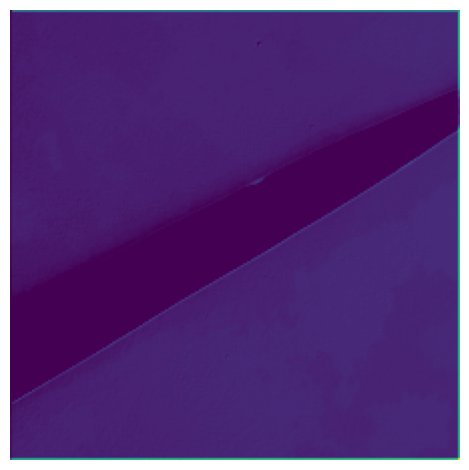

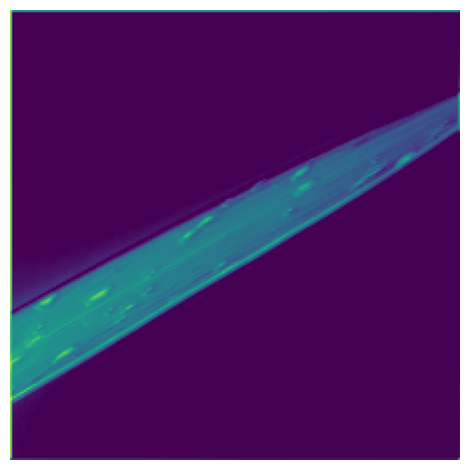

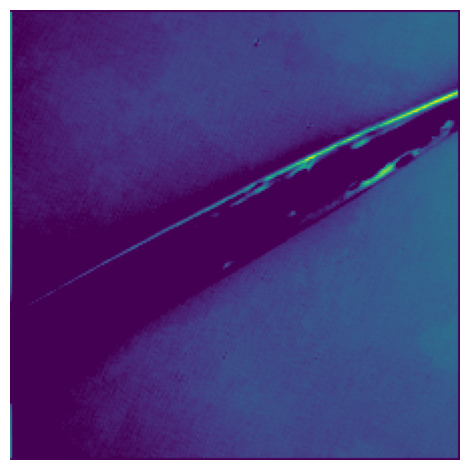

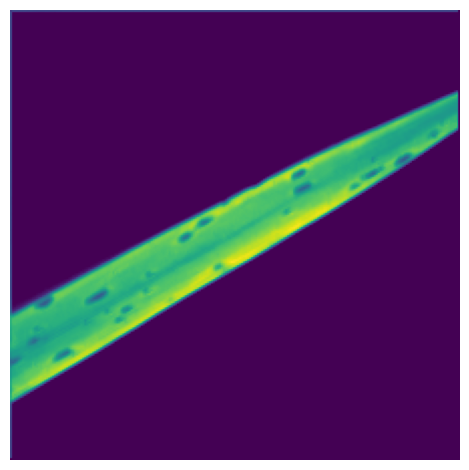

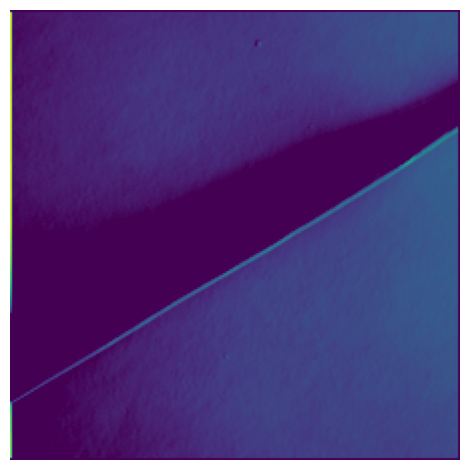

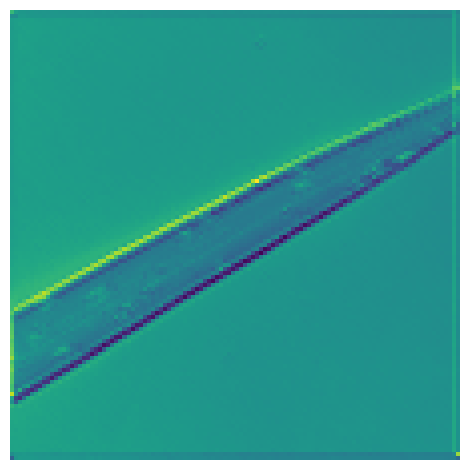

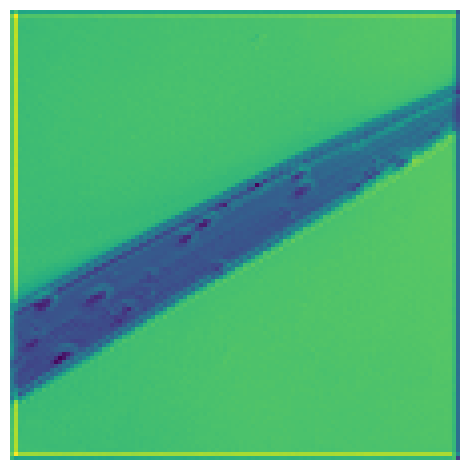

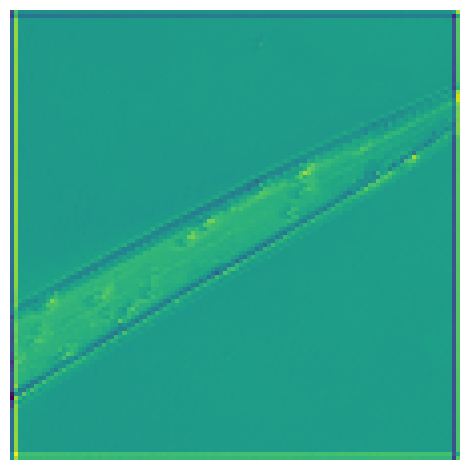

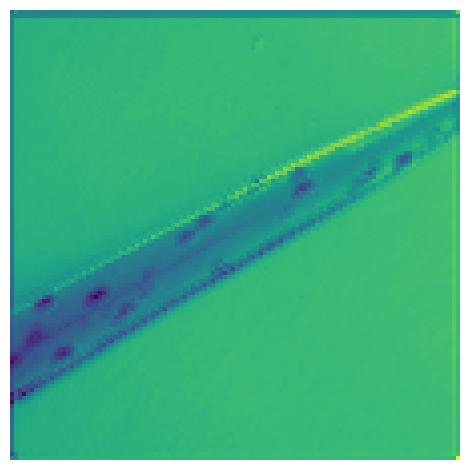

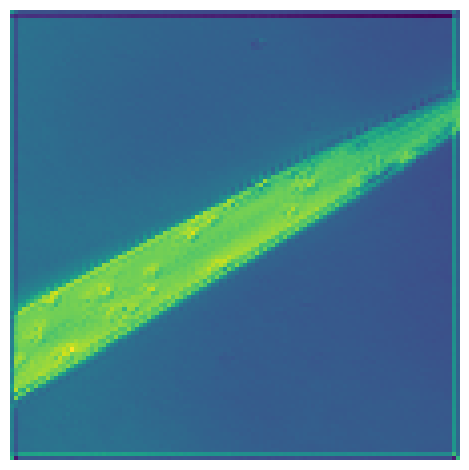

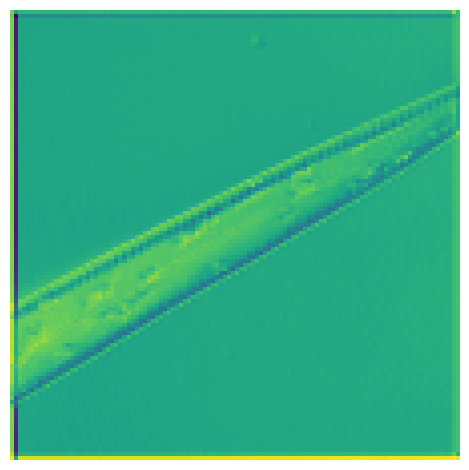

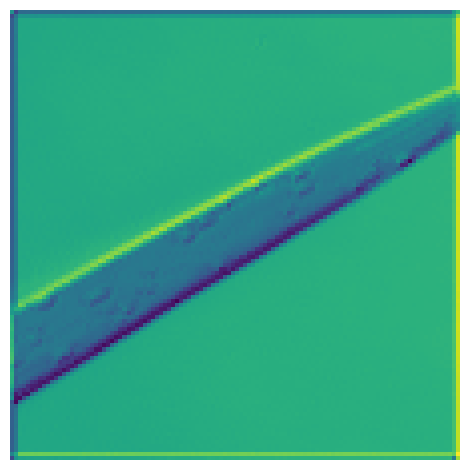

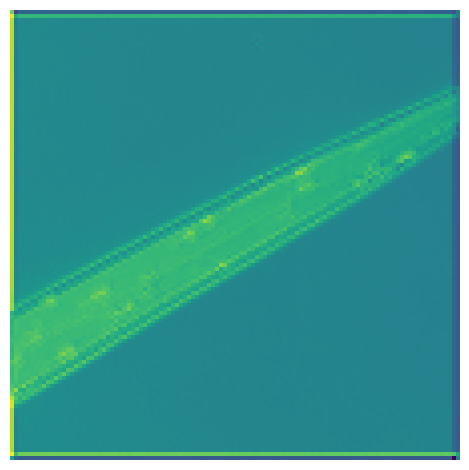

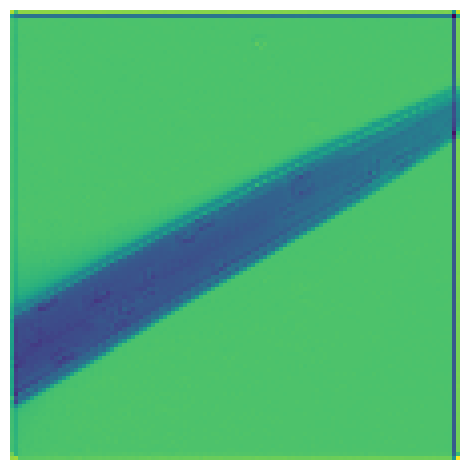

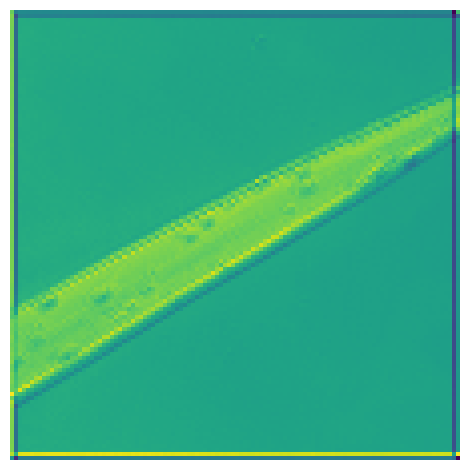

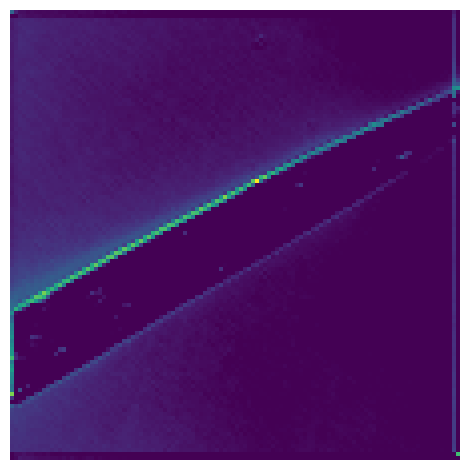

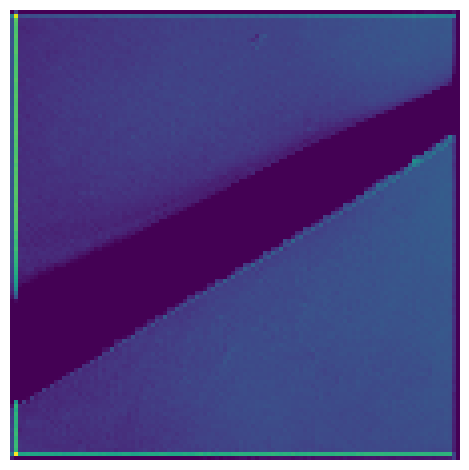

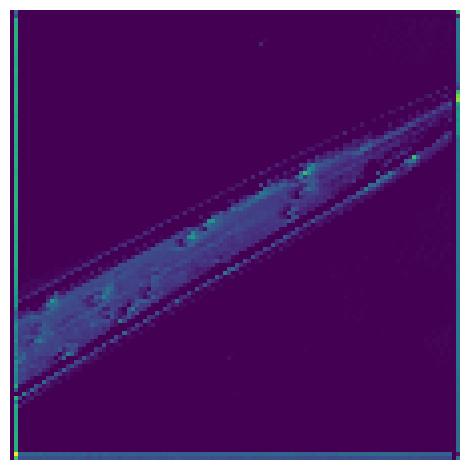

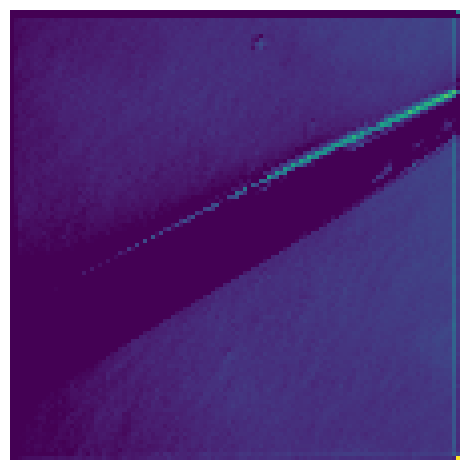

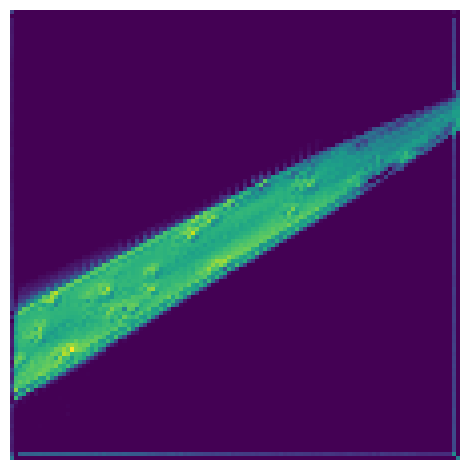

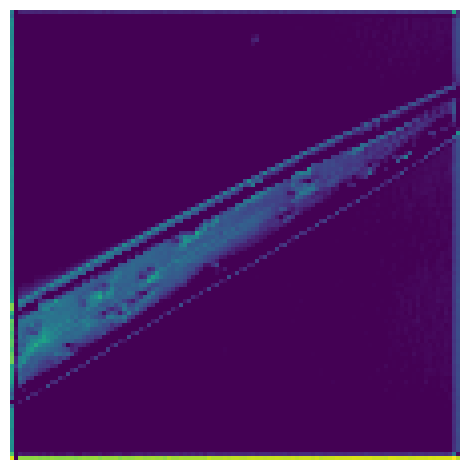

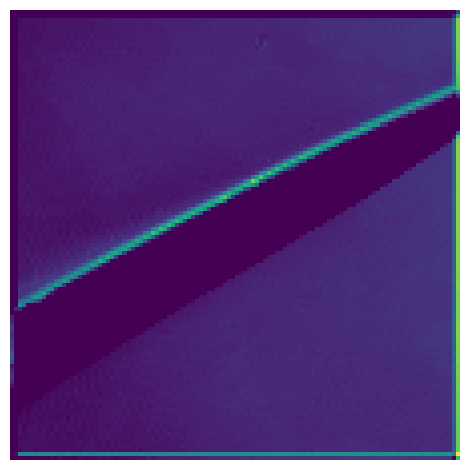

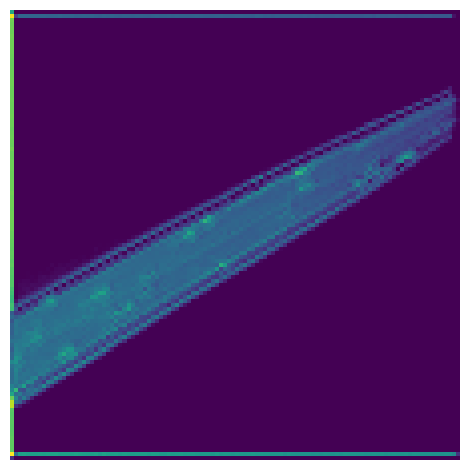

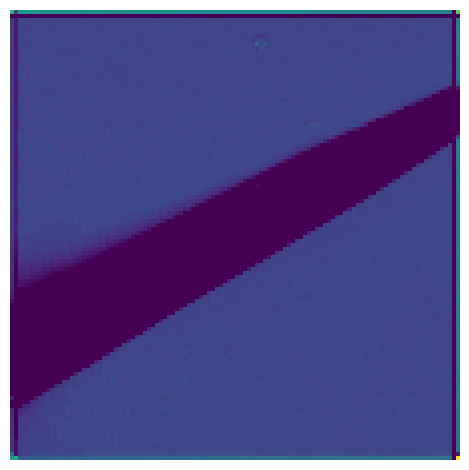

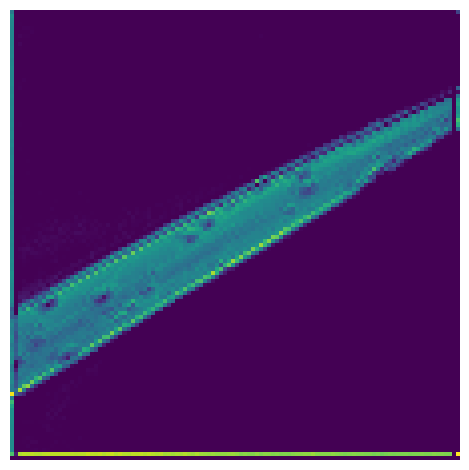

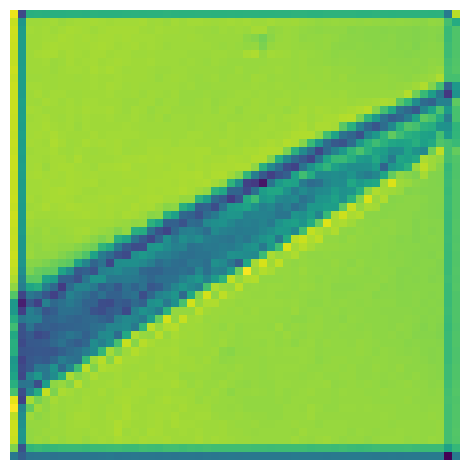

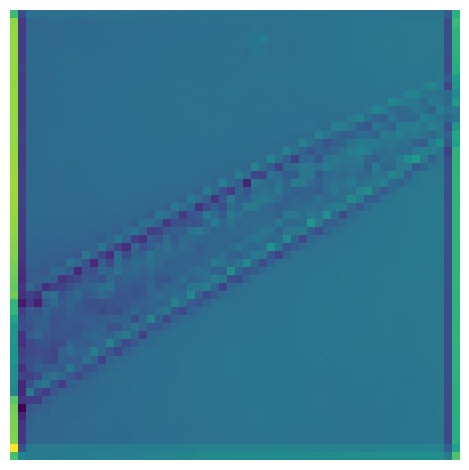

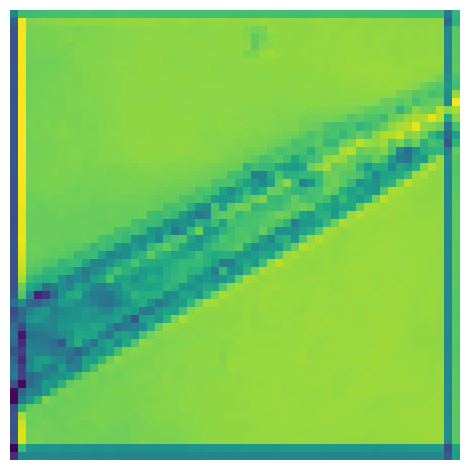

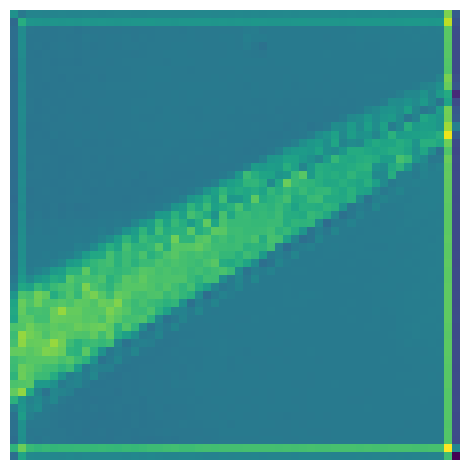

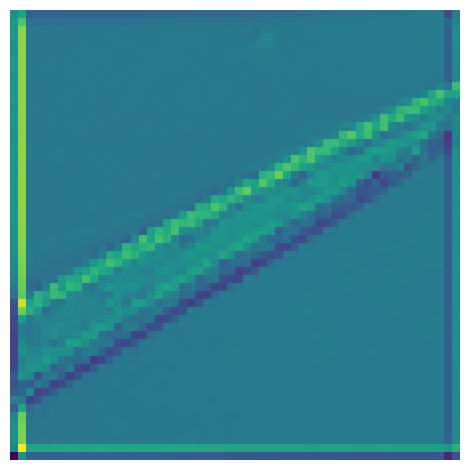

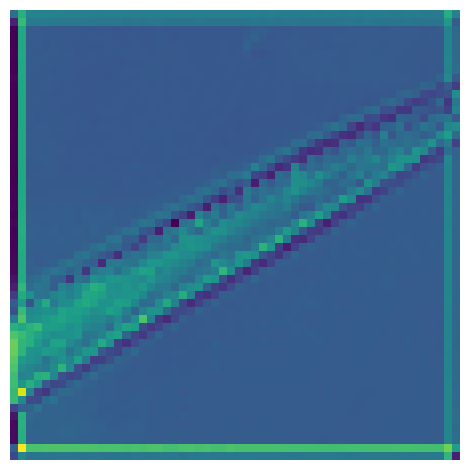

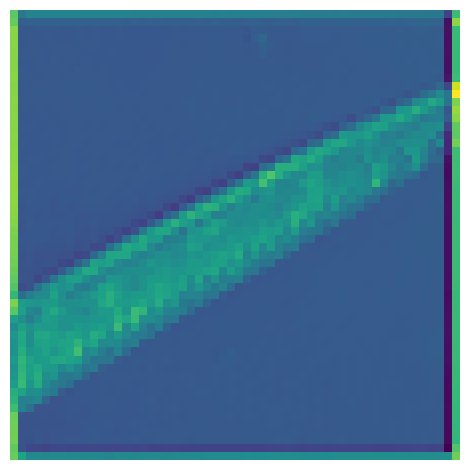

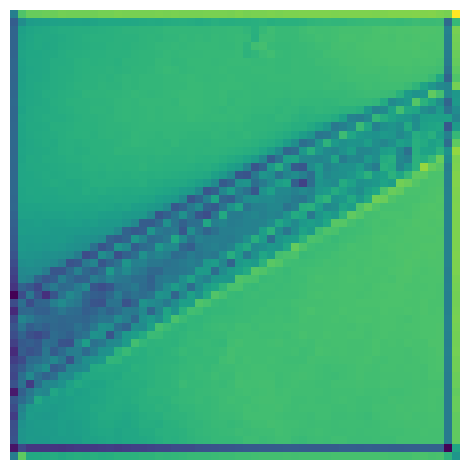

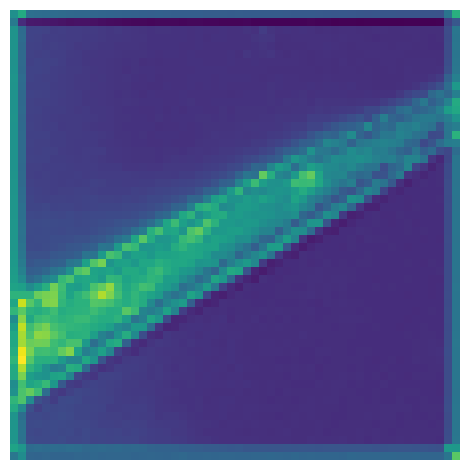

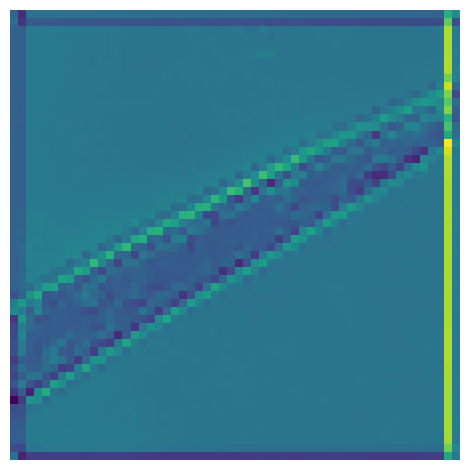

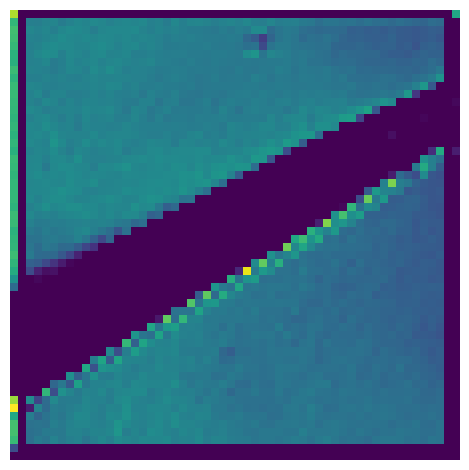

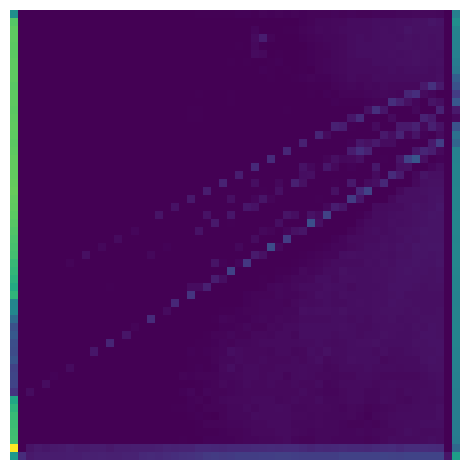

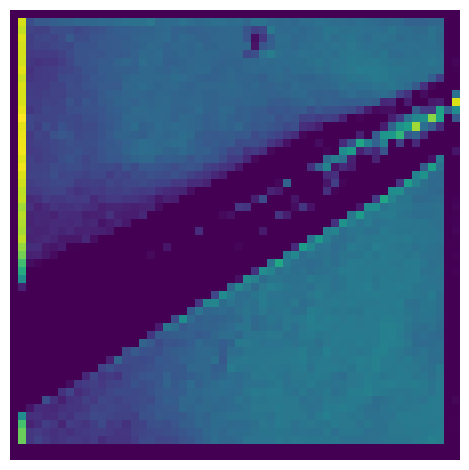

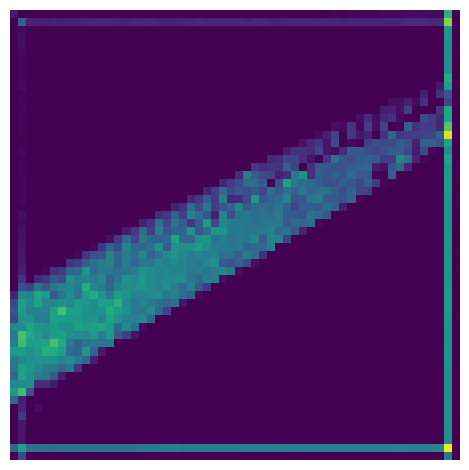

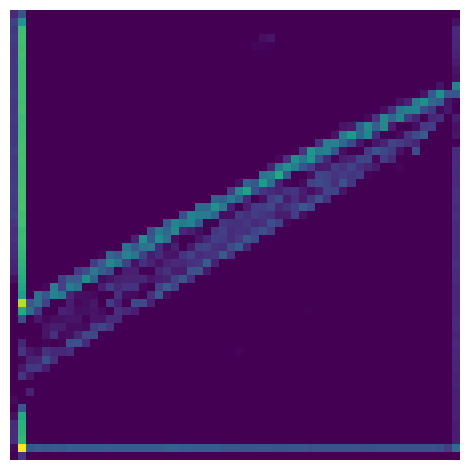

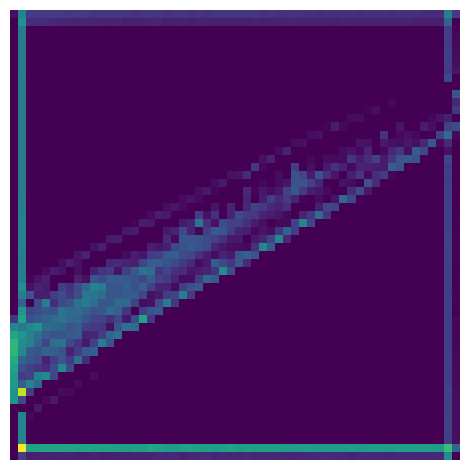

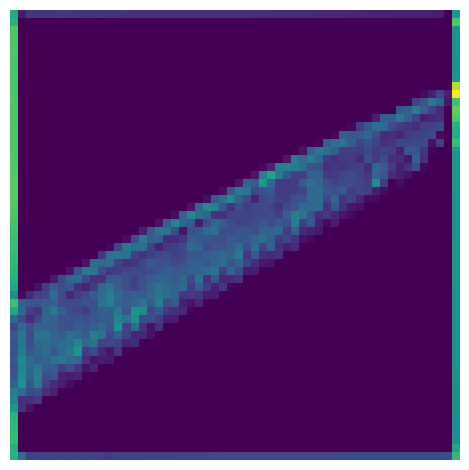

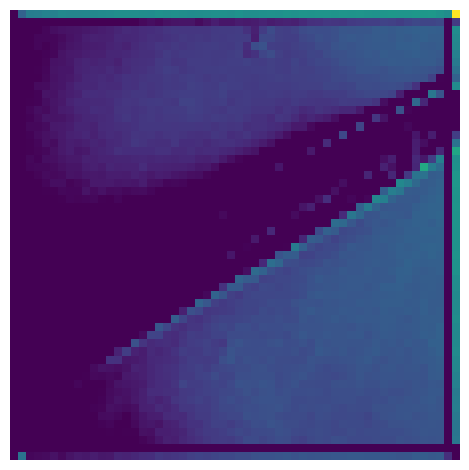

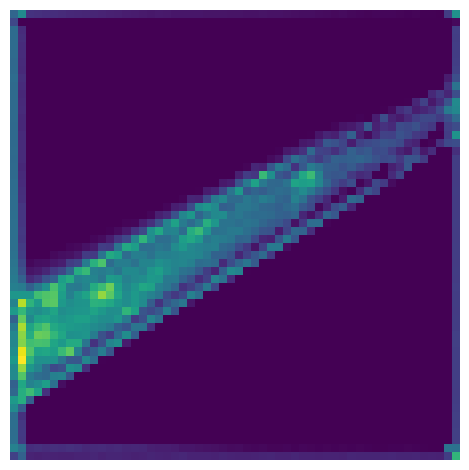

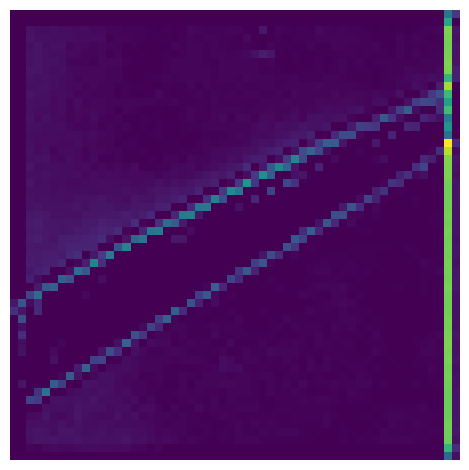

In [24]:
for name in activation1:
    folder_path = os.path.join('custom_12', name)
    file = name

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    if file in activation1:
        num_images = min(max(3, activation1[file].shape[1]), 10)
        for i in range(num_images):
            fig, ax = plt.subplots(1, 1)
            ax.imshow(activation1[file][0, i].cpu().numpy())
            ax.axis('off')
            plt.tight_layout()

            fig.savefig(f'{folder_path}/{file}-{i}.png', dpi=300, transparent=True)


tensor([[[[1.0000, 0.9725, 0.7686, 0.9137, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7373, 0.8941, 1.0000, 1.0000],
          [1.0000, 0.9647, 0.7373, 0.8784, 1.0000, 1.0000],
          [1.0000, 0.9529, 0.7059, 0.8745, 1.0000, 1.0000],
          [1.0000, 0.9451, 0.6941, 0.8392, 0.9922, 1.0000],
          [1.0000, 0.9490, 0.6824, 0.7882, 0.9882, 1.0000]],

         [[1.0000, 0.9647, 0.7098, 0.8902, 1.0000, 1.0000],
          [1.0000, 0.9686, 0.7725, 0.8980, 1.0000, 1.0000],
          [1.0000, 0.9608, 0.7529, 0.8706, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.6902, 0.8627, 0.9961, 1.0000],
          [1.0000, 0.9451, 0.7059, 0.8078, 0.9922, 1.0000],
          [1.0000, 0.9451, 0.6588, 0.7843, 0.9843, 1.0000]],

         [[1.0000, 0.9333, 0.4471, 0.7333, 1.0000, 1.0000],
          [1.0000, 0.9294, 0.4235, 0.6902, 1.0000, 1.0000],
          [1.0000, 0.9255, 0.4118, 0.6431, 0.9922, 1.0000],
          [1.0000, 0.9216, 0.3882, 0.6039, 0.9882, 1.0000],
          [1.0000, 0.9176, 0.3608, 0

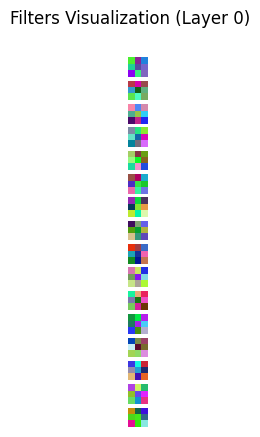

bias :tensor([-0.1456, -0.1780,  0.0672,  0.0506,  0.1622, -0.0818, -0.0673,  0.1012,
        -0.0414, -0.0697,  0.0672, -0.0780, -0.1212,  0.1046, -0.0132,  0.0953])


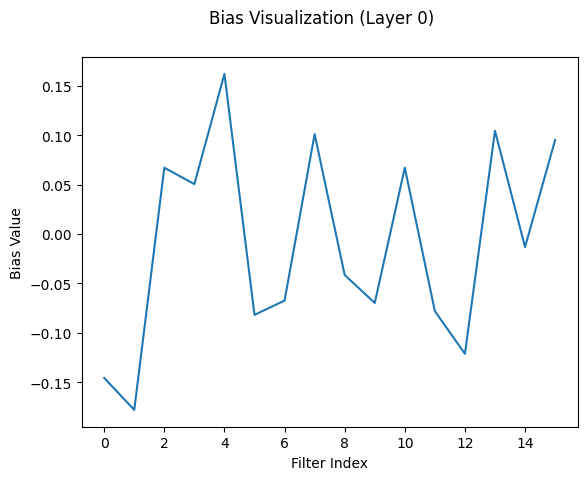

fitur :tensor([[[[-0.0985, -0.1805, -0.1419, -0.1676, -0.1344, -0.1948],
          [-0.2086, -0.3683, -0.2956, -0.2575, -0.2570, -0.3312],
          [-0.2084, -0.3684, -0.3183, -0.2407, -0.2565, -0.3325],
          [-0.2083, -0.3690, -0.3202, -0.2595, -0.2576, -0.3337],
          [-0.2074, -0.3693, -0.3375, -0.2542, -0.2687, -0.3353],
          [-0.3015, -0.4129, -0.3760, -0.2775, -0.2993, -0.3699]],

         [[-0.3321, -0.2595, -0.2071, -0.2777, -0.2881, -0.2947],
          [-0.4467, -0.4281, -0.4125, -0.4553, -0.4961, -0.4001],
          [-0.4478, -0.4380, -0.4376, -0.4706, -0.4964, -0.4009],
          [-0.4472, -0.4316, -0.4138, -0.4693, -0.4958, -0.3995],
          [-0.4457, -0.4230, -0.4049, -0.4576, -0.4929, -0.3989],
          [-0.6430, -0.6393, -0.5251, -0.5925, -0.7124, -0.6130]],

         [[ 0.1218, -0.2709, -0.1958, -0.0671, -0.1137, -0.1974],
          [ 0.4207,  0.2045,  0.2360,  0.3772,  0.4085,  0.1475],
          [ 0.4220,  0.2047,  0.2224,  0.3763,  0.4043,  0.1472],

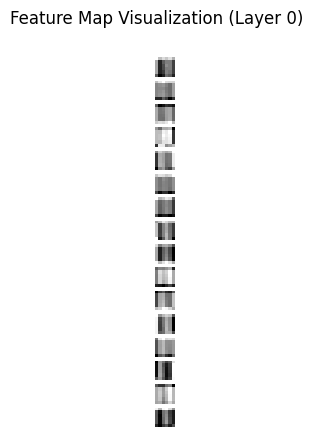

relu :tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.1218, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4207, 0.2045, 0.2360, 0.3772, 0.4085, 0.1475],
          [0.4220, 0.2047, 0.2224, 0.3763, 0.4043, 0.1472],
          [0.4207, 0.1884, 0.1985, 0.3695, 0.4113, 0.1484],
          [0.4185, 0.1860, 0.1

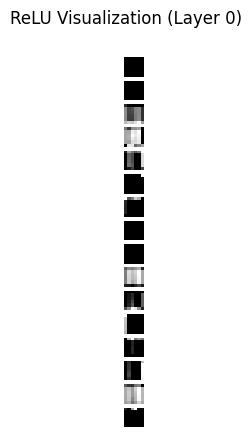

In [25]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

def visualize_filters(model, layer_idx):
    layer = model.feature[layer_idx][0]
    filters = layer.weight.data
    filters = filters - filters.min()
    filters = filters / filters.max()

    fig, axs = plt.subplots(filters.size(0))
    fig.suptitle('Filters Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        filter_img = filters[i].permute(1, 2, 0).cpu().numpy()
        ax.imshow(filter_img.squeeze(), cmap='gray')  
        ax.axis('off')
        print(f"filer :{filter_img}")

    plt.show()
    
def visualize_bias(model, layer_idx):
    layer = model.feature[layer_idx][0]
    bias = layer.bias.data

    fig, ax = plt.subplots()
    fig.suptitle('Bias Visualization (Layer {})'.format(layer_idx))

    ax.plot(bias.cpu().numpy())
    ax.set_xlabel('Filter Index')
    ax.set_ylabel('Bias Value')
    print(f"bias :{bias}")
    plt.show()
    
    

def visualize_feature_maps(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    activations = activations.detach()

    fig, axs = plt.subplots(activations.size(1))
    fig.suptitle('Feature Map Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"fitur :{activations}")

    plt.show()

def visualize_relu(model, layer_idx, input_image):
    activations = model.feature[0][layer_idx](input_image)
    relu_activations = torch.relu(activations)
    relu_activations = relu_activations.detach()

    fig, axs = plt.subplots(relu_activations.size(1))
    fig.suptitle('ReLU Visualization (Layer {})'.format(layer_idx))

    for i, ax in enumerate(axs):
        ax.imshow(relu_activations[0, i, :, :].cpu(), cmap='gray')  
        ax.axis('off')
        print(f"relu :{relu_activations}")

    plt.show()

output_size = 10  
model = CNNpenyakitPadi(output_size)

transform = transforms.Compose([
    transforms.Resize((6,6)),
    transforms.ToTensor()
])

image_path = '/kaggle/input/rice-desease/datapadi/test/brown_spot/brown_val (50).jpg' 
input_image = Image.open(image_path)
input_image = transform(input_image).unsqueeze(0)


print(input_image)


visualize_filters(model, 0)

visualize_bias(model, 0)

visualize_feature_maps(model, 0, input_image)

visualize_relu(model, 0, input_image)